In [1]:
using Revise
using RMMMDNets

;

┌ Info: Precompiling RMMMDNets [7ea7fd3b-14e3-4223-94d2-c341911ad28e]
└ @ Base loading.jl:1242
┌ Info: Skipping precompilation since __precompile__(false). Importing RMMMDNets [7ea7fd3b-14e3-4223-94d2-c341911ad28e].
└ @ Base loading.jl:1017
┌ Info: Recompiling stale cache file /afs/inf.ed.ac.uk/user/s16/s1672897/.julia/compiled/v1.2/MLToolkit/GGQB9.ji for MLToolkit [519e820e-097c-11e9-2274-1b004aeb0b9b]
└ @ Base loading.jl:1240


In [76]:
grampath = pathof(RMMMDNets) |> splitdir |> first |> splitdir |> first
hyperpath = "$grampath/examples/Hyper.toml"

dataset = begin
#     "gaussian"
#     "ring"
    "mnist"
#     "cifar10"
end

modelname = begin
#     "mmdnet"
#     "gan"
    "rmmmdnet"
end

argdict = parse_toml(hyperpath, dataset, modelname)
args = process_argdict(
    argdict;
#     override=(seed=1, Dhs_g="conv"),
#     suffix="noclip-with_regularizer"
)

;

┌ Info: Args
│   Dhs_g = 200,400,800
│   act = relu
│   dataset = mnist
│   sigma = 0.1,1,10
│   Dz = 100
│   batchsize = 200
│   opt = adam
│   norm = true
│   Df = 100
│   n_epochs = 10
│   actlast = sigmoid
│   beta1 = 0.5
│   modelname = rmmmdnet
│   Dhs_f = conv
│   batchsize_g = 200
│   base = uniform
│   lr = 0.001
│   seed = 1
└ @ MLToolkit.Scripting /afs/inf.ed.ac.uk/user/s16/s1672897/projects/MLToolkit.jl/src/Scripting/args.jl:45


In [77]:
dataloader, model, modelpath = run_exp(
    args; 
#     initonly=true,
#     model=model,
)

;

┌ Warning: args.act is ignored
└ @ RMMMDNets /afs/inf.ed.ac.uk/user/s16/s1672897/projects/GRAM-nets/GRAM.jl/src/RMMMDNets.jl:248
┌ Info: Init rmmmdnet with 1,095,292 parameters
│   logdir = mnist/rmmmdnet/Dhs_g=200,400,800-act=relu-dataset=mnist-sigma=0.1,1,10-Dz=100-batchsize=200-opt=adam-norm=true-Df=100-n_epochs=10-actlast=sigmoid-beta1=0.5-modelname=rmmmdnet-Dhs_f=conv-batchsize_g=200-base=uniform-lr=0.001-seed=1/10112019-20-37-40
└ @ RMMMDNets /afs/inf.ed.ac.uk/user/s16/s1672897/projects/GRAM-nets/GRAM.jl/src/RMMMDNets.jl:258
Training100%|███████████████████████████████████████████| Time: 0:04:07
┌ Info: Saved model at iteration 3000 to /afs/inf.ed.ac.uk/group/cup/data1/kai/logs/rmmmdnets/mnist/rmmmdnet/Dhs_g=200,400,800-act=relu-dataset=mnist-sigma=0.1,1,10-Dz=100-batchsize=200-opt=adam-norm=true-Df=100-n_epochs=10-actlast=sigmoid-beta1=0.5-modelname=rmmmdnet-Dhs_f=conv-batchsize_g=200-base=uniform-lr=0.001-seed=1/10112019-20-37-40/model.bson
│   log_step_increment = 0
└ @ MLTool

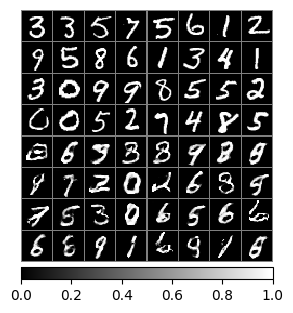

In [78]:
evaluate(model, dataloader).gen